# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2023-2024, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Maria de Neves de Fonseca (M.deNevesdeFonseca-1@student.tudelft.nl)
* (c) TU Delft, 2024

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Thomas Evers"
STUDENT_1_STUDENT_NUMBER = "5310121"
STUDENT_1_NETID = "thomasevers"
STUDENT_1_EMAIL = "t.evers-2@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

In [3]:
import sys
sys.path.append("C:/Users/thoma/OneDrive - Delft University of Technology/Documenten/UNI/Intelligent Control/ics-pa-sv")


# Task 3d - Fit a GP to the forward dynamics and visualize the phase plot (8p)
**Authors:** Giovanni Franzese (G.Franzese@tudelft.nl), Lorenzo Lyons (L.Lyons@tudelft.nl)

In [4]:
import gpytorch
from gpytorch.models import ApproximateGP
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from pathlib import Path
import random
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm  # progress bar

from utils import generate_training_data, plot_data

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)
# define path to folder that contains the datasets
datasets_dir = Path("datasets")

# Task 3d.1 - Create the Multi-input Multi-output Gaussian Process Model (1p)
The following GP model is a multi-input, multi-output model that only uses a sparse set of inducing points. Hence, it is a sparse variational approximation.

Everything is similar to before, but the resulting likelihood is now a multi-output.

```python
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=)
```
where `num_tasks` is the number of outputs to predict. 

The scale kernel should be different for each task because they can have different units of measure. This is achieved by setting batch_shape=torch.Size([num_tasks]). If you want to use the same scale kernel for all tasks, you can simply remove the batch_shape argument.

Define the covariance module as a Matern kernel with `nu=2.5`, with automatic relevance determination equal to `ard_num_dim`, which is equal to the number of columns of the inducing points and having a different output scale for each output.

In [5]:
class MultitaskGPModel(ApproximateGP):
    def __init__(self, num_tasks, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_tasks])
        )
        variational_strategy = (
            gpytorch.variational.IndependentMultitaskVariationalStrategy(
                gpytorch.variational.VariationalStrategy(
                    self,
                    inducing_points,
                    variational_distribution,
                    learn_inducing_locations=True,
                ),
                num_tasks=num_tasks,
                task_dim=-1,
            )
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ZeroMean()
        # ard_num_dim =
        # self.covar_module = gpytorch.kernels.ScaleKernel()
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)
        self.covar_module = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=inducing_points.shape[1], batch_shape=torch.Size([num_tasks]))
        

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Task 3d.2 - Create a `ForwardDynamicsModel` class that defines the GP model, the likelihood and trains the variational parameters (1p)
Define the GP model, likelihood and the ELBO inside the `ForwardDynamicsModel` class. Refer to the previous tasks for hints.

In [6]:
class ForwardDynamicsModel:
    def __init__(self, X, Y, n_ind=100, batch_size=256):
        self.X = X
        self.Y = Y
        # number of inducing points
        unique_random_indices = torch.randperm(len(X))[:n_ind]
        inducing_points = X[unique_random_indices]
        self.inducing_points = inducing_points
        self.batch_size = batch_size
        self.is_cuda = False
        # to plot the training loss convergence
        self.rmse_loss_vec = np.array([])

        # self.gp =
        # self.likelihood =
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.gp = MultitaskGPModel(num_tasks=2, inducing_points=inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)

    def to_cuda(self):
        self.gp = self.gp.cuda()
        self.likelihood = self.likelihood.cuda()
        self.X = self.X.cuda()
        self.Y = self.Y.cuda()
        self.is_cuda = True

    def predict(self, X_pred):
        if self.is_cuda:
            X_pred = X_pred.cuda()
        return self.gp(X_pred)

    def train(self, num_epochs=3):
        self.gp = self.gp.double()
        self.likelihood = self.likelihood.double()
        self.X = self.X.double()
        self.Y = self.Y.double()
        self.train_dataset = TensorDataset(self.X, self.Y)
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True
        )
        self.gp.train()
        self.likelihood.train()

        optimizer = torch.optim.Adam(
            [
                {"params": self.gp.parameters()},
                {"params": self.likelihood.parameters()},
            ],
            lr=0.01,
        )

        # Our loss object. We're using the VariationalELBO
        # self.mll =
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.mll = gpytorch.mlls.VariationalELBO(self.likelihood, self.gp, num_data=len(self.train_dataset))    

        self.rmse_loss_vec = np.zeros(num_epochs)
        for i in tqdm(range(num_epochs)):
            loss_sum = 0.0
            for x_batch, y_batch in self.train_loader:
                optimizer.zero_grad()
                output = self.gp(x_batch)
                loss = -self.mll(output, y_batch)
                loss.backward()
                optimizer.step()
                loss_sum += loss.detach().cpu()
            self.rmse_loss_vec[i] = (
                torch.sqrt(loss_sum / len(self.train_loader)).detach().item()
            )

    def plot_convergence(self, experiment_name: str):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.rmse_loss_vec, label="loss")
        ax.set_xlabel("Epochs")
        ax.set_ylabel(r"Trainings RMSE for $\hat{\ddot{\theta}}$ [rad/s^2]")
        plt.savefig(
            str(outputs_dir / f"task_3d_training_convergence_{experiment_name}.pdf")
        )

    def print_info(self):
        with torch.no_grad():
            print("Training finished with the following statistics.")
            print("Lengthscale:\n", self.gp.covar_module.lengthscale)
            print("Outputscale:\n", self.gp.covar_module.lengthscale)
            print("ELBO:\n", self.mll(self.gp(self.X), self.Y).item())

## Task 3d.3 - Train a GP on the dataset with large oscillations and visualize the phase portrait (2p)
### Task 3d.3.1 - Load the dataset with large oscillations and visualize it (0p)
Load the dataset generated by initializing the double pendulum close to the tip-up configuration (without any external torques applied).

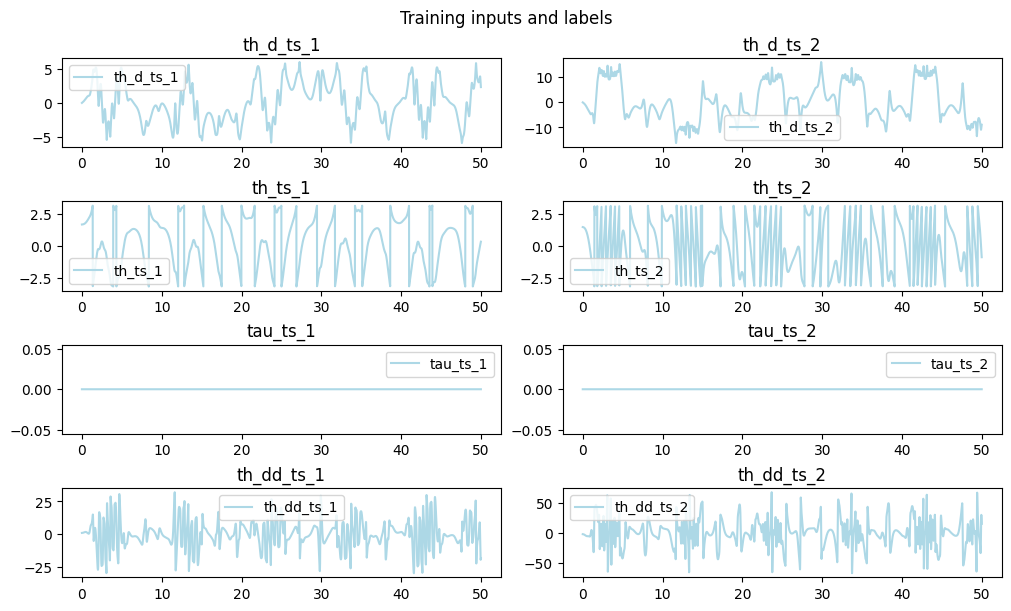

In [7]:
# load data generated in task 3c
dataset_name_big_osc = "trajectory_zero_gains_big_osc"
df_big_osc = pd.read_csv(datasets_dir / f"{dataset_name_big_osc}.csv")

# indicate input X and Y labels training data
input_columns = ["th_d_ts_1", "th_d_ts_2", "th_ts_1", "th_ts_2", "tau_ts_1", "tau_ts_2"]
output_columns = ["th_dd_ts_1", "th_dd_ts_2"]

# plot the training dataset
plot_data(
    df_big_osc,
    input_columns,
    output_columns,
    filepath=str(outputs_dir / f"task_3d-3_dataset_plot_{dataset_name_big_osc}.pdf"),
)

# generate torch tensors for training
X_big_osc, Y_big_osc = generate_training_data(df_big_osc, input_columns, output_columns)

### Task 3d.3.2 - Train the GP model (0.5p)
Initialize the ForwardDynamicsModel and **train it** using the dataset previously loaded.

  0%|          | 0/100 [00:00<?, ?it/s]

Training finished with the following statistics.
Lengthscale:
 tensor([[[10.3944,  6.8443,  0.9373,  1.0942,  0.6931,  0.6931]],

        [[15.3771, 14.0721,  0.7476,  0.8259,  0.6931,  0.6931]]],
       dtype=torch.float64)
Outputscale:
 tensor([[[10.3944,  6.8443,  0.9373,  1.0942,  0.6931,  0.6931]],

        [[15.3771, 14.0721,  0.7476,  0.8259,  0.6931,  0.6931]]],
       dtype=torch.float64)
ELBO:
 tensor(-12.1247, dtype=torch.float64)


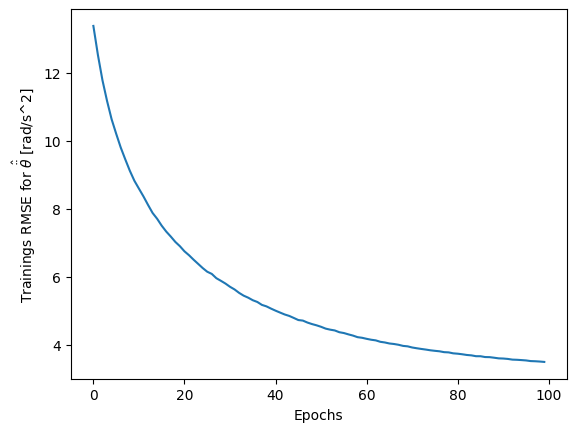

In [9]:
# set random seed
torch.manual_seed(42)

# forward_model_big_osc =
# YOUR CODE to train the gp
# YOUR CODE HERE
# raise NotImplementedError()
forward_model_big_osc = ForwardDynamicsModel(X_big_osc, Y_big_osc)
forward_model_big_osc.train(100)

# print model info
forward_model_big_osc.print_info()

# plot convergence of training loss
forward_model_big_osc.plot_convergence(dataset_name_big_osc)

### Task 3d.3.3 - Visualize the learned dynamics with a phase portrait (0.5p)
For more information about phase portraits, please consult the [Wikipedia article](https://en.wikipedia.org/wiki/Phase_portrait).

Since we cannot visualize the phase portrait of a double pendulum in 2D (it works for a standard pendulum, though), we are going to lock the second DoF by considering the configuration and its velocity equal to the one of the first joint, i.e., no relative movement. We are studying the unforced dynamics of the systems. Hence, the external torques (for both joints) are set to zero. 

Define `tau1`and `tau2` used for plotting correctly.

In [11]:
theta_dot_min, theta_dot_max = (-8, 8)

# Create a grid of input points for prediction
theta_range = np.linspace(-np.pi, np.pi, 100)
theta_dot_range = np.linspace(theta_dot_min, theta_dot_max, 100)

theta_grid, theta_dot_grid = np.meshgrid(theta_range, theta_dot_range)

# Set torques to zero
# tau1 =
# tau2 =
# YOUR CODE HERE
# raise NotImplementedError()
tau1 = torch.zeros_like(torch.tensor(theta_grid.flatten()))
tau2 = torch.zeros_like(torch.tensor(theta_grid.flatten()))

# Create input points
input_points = np.column_stack(
    (
        theta_dot_grid.flatten(),
        theta_dot_grid.flatten(),
        theta_grid.flatten(),
        theta_grid.flatten(),
        tau1.flatten(),
        tau2.flatten(),
    )
)

X_test = torch.tensor(input_points, dtype=torch.float32)

### Task 3d.3.4 - Predict mean and standard deviation of each of the outputs using the learned model (1p)

In [12]:
# Model prediction on X_test
# Y_pred_mean =
# Y_pred_std =
# YOUR CODE HERE
# raise NotImplementedError()
Y_pred_mean = forward_model_big_osc.predict(X_test).mean
Y_pred_std = forward_model_big_osc.predict(X_test).variance.sqrt()

Y_pred_mean_grid_big_osc = Y_pred_mean[:, 0].view(100, 100).detach().cpu().numpy()
Y_pred_std_grid_big_osc = Y_pred_std[:, 0].view(100, 100).detach().cpu().numpy()

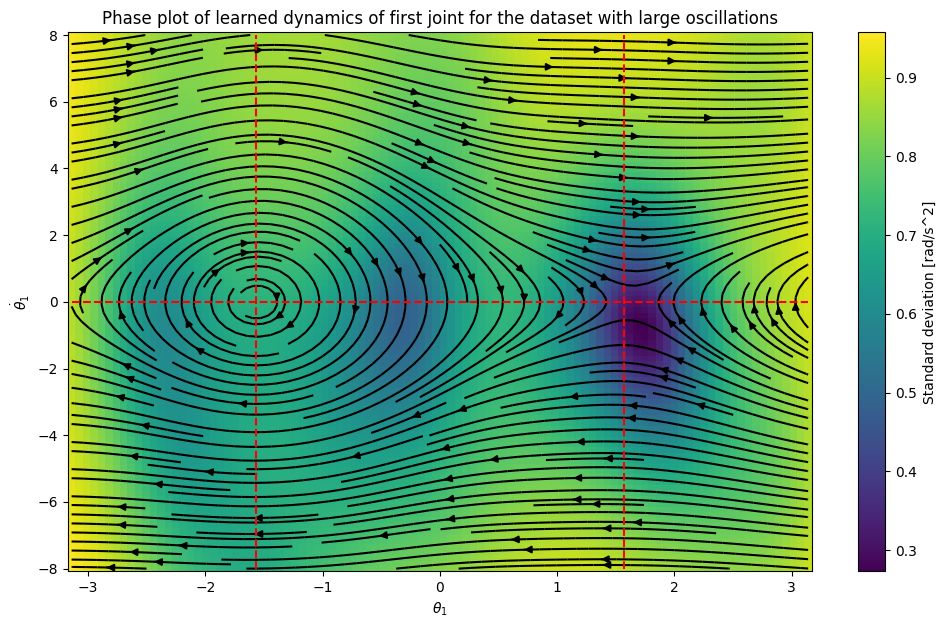

In [13]:
# Plotting the phase portrait
fig, ax = plt.subplots(figsize=(12, 7))

ax.streamplot(
    theta_grid,
    theta_dot_grid,
    theta_dot_grid,
    Y_pred_mean_grid_big_osc,
    density=2,
    color="black",
)
ax.vlines(-np.pi / 2, theta_dot_min, theta_dot_max, color="red", linestyles="dashed")
ax.vlines(np.pi / 2, theta_dot_min, theta_dot_max, color="red", linestyles="dashed")
ax.hlines(0, -np.pi, np.pi, color="red", linestyles="dashed")
cax = ax.pcolormesh(theta_grid, theta_dot_grid, Y_pred_std_grid_big_osc, cmap="viridis")
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\dot{\theta}_1$")
ax.title.set_text(
    "Phase plot of learned dynamics of first joint for the dataset with large oscillations"
)
cbar = fig.colorbar(cax)
cbar.set_label("Standard deviation [rad/s^2]")
plt.savefig(str(outputs_dir / f"task_3d-3_phase_portrait_{dataset_name_big_osc}.pdf"))

## Task 3d.4 - Train a GP on the dataset with small oscillations and visualize phase portrait (1p)
### Task 3d.4.1 - Load the dataset with small oscillations and visualize it (0p)
Load the dataset generated by initializing the double pendulum close to the tip-down configuration (without any external torques applied).

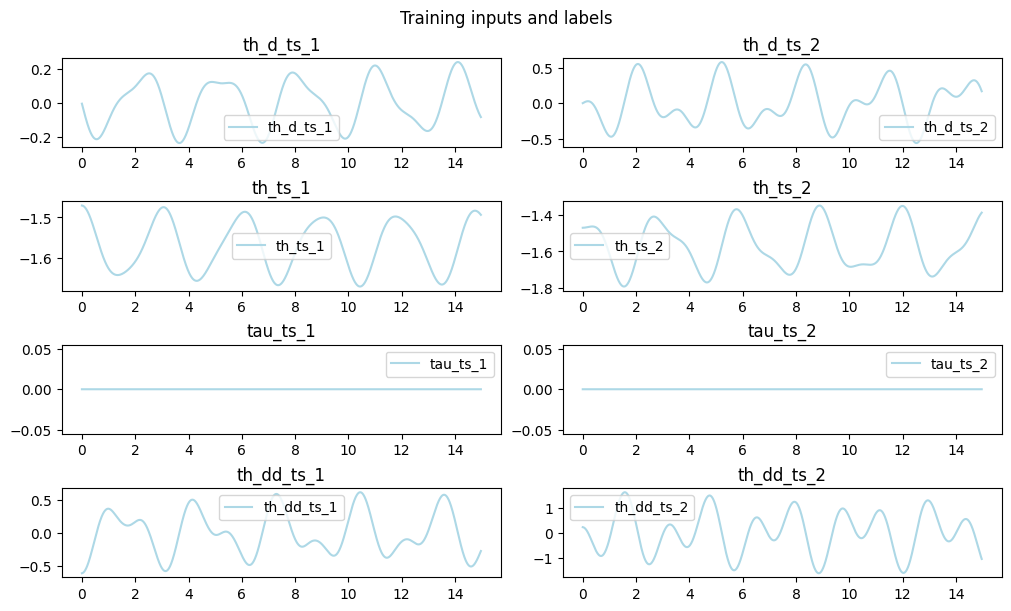

In [14]:
# load data generated in task 3c
dataset_name_small_osc = "trajectory_zero_gains_small_osc"
df_small_osc = pd.read_csv(datasets_dir / f"{dataset_name_small_osc}.csv")

# indicate input X and Y labels training data
input_columns = ["th_d_ts_1", "th_d_ts_2", "th_ts_1", "th_ts_2", "tau_ts_1", "tau_ts_2"]
output_columns = ["th_dd_ts_1", "th_dd_ts_2"]

# plot the GP training data
plot_data(
    df_small_osc,
    input_columns,
    output_columns,
    filepath=str(outputs_dir / f"task_3d-4_dataset_plot_{dataset_name_small_osc}.pdf"),
)

# generate torch tensors for training
X_small_osc, Y_small_osc = generate_training_data(
    df_small_osc, input_columns, output_columns
)

### Task 3d.4.2 - Train the Forward Dynamic model (0.5p)
Initialize the model and **train it** using the dataset previously loaded.

  0%|          | 0/100 [00:00<?, ?it/s]

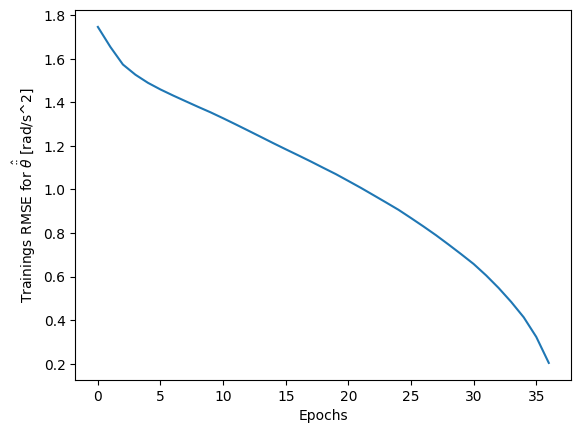

In [17]:
# set random seed
torch.manual_seed(42)

# forward_model_small_osc =
# YOUR CODE HERE
# raise NotImplementedError()
forward_model_small_osc = ForwardDynamicsModel(X_small_osc, Y_small_osc)
forward_model_small_osc.train(100)

# plot convergence of training loss
forward_model_small_osc.plot_convergence(dataset_name_small_osc)

### Task 3d.4.3 - Visualize the learned dynamics with a phase portrait (0.5p)

In [24]:
# Model prediction on X_test
# Y_pred_mean =
# Y_pred_std =
# YOUR CODE HERE
# raise NotImplementedError()
Y_pred_mean = forward_model_small_osc.predict(X_test).mean
Y_pred_std = forward_model_small_osc.predict(X_test).variance.sqrt()
print(Y_pred_mean.shape, 
      Y_pred_std.shape)
Y_pred_mean_grid_small_osc = Y_pred_mean[:, 0].view(100, 100).detach().cpu().numpy()
Y_pred_std_grid_small_osc = Y_pred_std[:, 0].view(100, 100).detach().cpu().numpy()

torch.Size([10000, 2]) torch.Size([10000, 2])


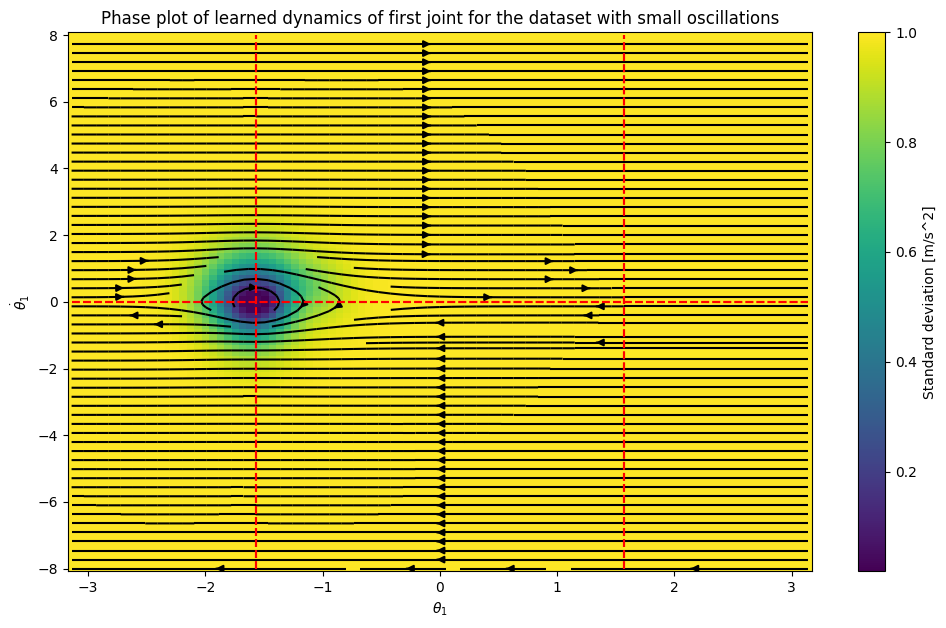

In [20]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 7))

ax.streamplot(
    theta_grid,
    theta_dot_grid,
    theta_dot_grid,
    Y_pred_mean_grid_small_osc,
    density=2,
    color="black",
)
ax.vlines(-np.pi / 2, theta_dot_min, theta_dot_max, color="red", linestyles="dashed")
ax.vlines(np.pi / 2, theta_dot_min, theta_dot_max, color="red", linestyles="dashed")
ax.hlines(0, -np.pi, np.pi, color="red", linestyles="dashed")
cax = ax.pcolormesh(
    theta_grid, theta_dot_grid, Y_pred_std_grid_small_osc, cmap="viridis"
)
ax.vlines(-np.pi / 2, theta_dot_min, theta_dot_max, color="red", linestyles="dashed")
ax.vlines(np.pi / 2, theta_dot_min, theta_dot_max, color="red", linestyles="dashed")
ax.hlines(0, -np.pi, np.pi, color="red", linestyles="dashed")
ax.set_xlabel(r"$\theta_1$")
ax.set_ylabel(r"$\dot{\theta}_1$")
ax.title.set_text(
    "Phase plot of learned dynamics of first joint for the dataset with small oscillations"
)
cbar = fig.colorbar(cax)
cbar.set_label("Standard deviation [m/s^2]")
plt.savefig(str(outputs_dir / f"task_3d-4_phase_portrait_{dataset_name_small_osc}.pdf"))

## Task 3d.5 - Comparison of phase portraits (3p)
Compare the two-phase portraits. In particular, explain why the colors and the vector field are different on the right side of the phase plot. Write your answer below. 

In [23]:
raise  "Still answer the questions below"

TypeError: exceptions must derive from BaseException